**Oreum Industries Internal Project, 2024Q3**

---

# 101_Exponential_Regression.ipynb

### Survival Regression Demo in `oreum_survival`

Demonstrate Survival Regression Modelling using Bayesian inference and a 
Bayesian workflow, specifically using the `pymc` & `arviz` ecosystem.

**In this Notebook:**

+ We extend our basic understanding with worked examples of parametric and semi-parametric models in the Exponential
architecture family, using our real-world observational censored dataset.
+ Specifically: **A Parametric Regression aka Accelerated Failure Time Model: Exponential**

## Contents

+ [Setup](#Setup)

+ [0. Load Dataset](#0.-Load-Dataset)

+ [1. Model Description](#1.-Model-Description)

+ [2. Packaged Frequentist Model `ExponentialFitter`](#2.-Packaged-Frequentist-Model-`ExponentialFitter`)

+ [3. Custom Bayesian Model `ExponentialRegression`](#3.-Custom-Bayesian-Model-`ExponentialRegression`)

---


# Setup

## Imports

In [ ]:
import sys
from pathlib import Path

import arviz as az
import lifelines as sa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from oreum_core import curate, eda
from oreum_core import model_pymc as mt
from pyprojroot.here import here

# prepend local project src files
module_path = here('src').resolve(strict=True)
if str(module_path) not in sys.path:
    sys.path.insert(0, str(module_path))


from engine import logger, utils
from model import exponential

import warnings  # isort:skip # suppress seaborn, it's far too chatty

warnings.simplefilter(action='ignore', category=FutureWarning)  # isort:skip
import seaborn as sns

/Users/jon/miniforge/envs/oreum_survival/lib/python3.11/site-packages/pymc/util.py:38: FutureWarning: dataset_to_point_list has been moved to backends.arviz. Importing from util will fail in a future release.
  warnings.warn(


##### Notebook config

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

log = logger.get_logger('101_Exponential_Regression', notebook=True)
_ = logger.get_logger('oreum_core', notebook=True)

## Local Functions and Global Vars

In [3]:
LOAD_FROM_CSV = True
RNG = np.random.default_rng(seed=42)

## Data Connections and Helper Objects

In [4]:
csvio = curate.PandasCSVIO(here(Path('data', 'raw', 'verbatim')).resolve(strict=True))
ppqio = curate.PandasParquetIO(here(Path('data', 'prepared')).resolve(strict=True))
mdlio = mt.PYMCIO(here(Path('data', 'models')).resolve(strict=True))
figio = eda.FigureIO(here(Path('plots')).resolve(strict=True))

---

---

# 0. Load Dataset

In [5]:
dfr = csvio.read(fn='mastectomy', index_col='rowid')
eda.display_ht(dfr)

,time,event,metastized
rowid,,,
0,23,True,no
1,47,True,no
2,69,True,no
41,212,False,yes
42,217,False,yes
43,225,False,yes


'Shape: (44, 3), Memsize 0.0 MB'

##### Correct dtypes etc

In [6]:
df = dfr.copy()
df['pid'] = ['p{}'.format(x) for x in range(len(df))]
df = df.reset_index(drop=True).set_index('pid')
df.rename(columns={'time': 'duration', 'event': 'death', 'metastized': 'met'}, inplace=True)
df['death'] = df['death'].astype(bool)
df['met'] = df['met'].apply(lambda x: True if str(x).strip() == 'yes' else False)
eda.describe(df)

,28,3,33,dtype,count_null,count_inf,count_zero,count_unique,top,freq,sum,mean,std,min,25%,50%,75%,max
ft,,,,,,,,,,,,,,,,,,
index: pid,p28,p3,p33,object,0,NaN,NaN,44,p0,1,NaN,NaN,NaN,p0,NaN,NaN,NaN,p9
duration,68,70,109,int64,0,0.0,0.0,NaN,NaN,NaN,4251.0,96.61,69.87,5.0,38.75,73.5,145.75,225.0
death,True,False,False,bool,0,NaN,NaN,2,True,26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
met,True,False,True,bool,0,NaN,NaN,2,True,32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


'Shape: (44, 4), Memsize 0.0 MB'

---

---

# 1. Model Description

## 1.1 "Accelerated Failure Time" is a baroque term for parameterising $\pi(t)$ with regression terms

The Accelerated Failure Time AFT model is a parameterisation of $\pi(t)$ into a baseline function $\pi_{0}$ and a
multiplying value $\chi$:

$$
\begin{aligned}
\pi &= \pi_{0} \cdot \chi \\
\end{aligned}
$$

Using the fundamental relationships we can alternatively state $\chi$ as an "acceleration" factor which brings a 
baseline survival function $S(t)_{0}$ "forwards" in observed time:

$$
\begin{aligned}
\lambda(t) \cdot S(t) &= \lambda(t) \cdot S_{0}(t) \cdot \chi \\
S(t) &= S_{0}(t) \cdot \chi \\
S_{0}(t) &= \frac{S(t)}{\chi} \\
\end{aligned}
$$

Obviously a static $\chi$ isn't particularly useful, but if we simply require that it have range $\chi \in [0, \infty)$ 
we can estimate it using a suitable function $f$ to regress onto features $x$ of observations $i$ and time $t$:

$$
\begin{aligned}
\chi_{i} &= f(\mathbf{x}_{i}, t)\\
\end{aligned}
$$


$$
\begin{aligned}
\chi_{i} &= \exp(\mathbf{\beta}^{T}\mathbf{x}_{i})\\
\text{... so:}\\
\pi_{i} &= \pi_{0} \exp(\mathbf{\beta}^{T}\mathbf{x}_{i})\\
\text{... and:}\\
\pi_{i} &= \pi_{0} \exp(\mathbf{\beta}^{T}\mathbf{x}_{i})\\
        &= \exp(\beta_{0}) \exp(\mathbf{\beta}^{T}\mathbf{x}_{i})\\
\end{aligned}
$$

For additional insight, log both sides and note that this has the form of a 
conventional linear model with error term $\epsilon = \log \pi_{0} = \beta_{0}$:

$$
\begin{aligned}
\log \pi_{i} &= \mathbf{\beta}^{T}\mathbf{x}_{i} + \log \pi_{0} \\
             &= \mathbf{\beta}^{T}\mathbf{x}_{i} + \beta_{0} \\
\end{aligned}
$$


**IMPORTANT NOTE**
+ So far, this parameterisation doesn't have anything to say about the functional form of $\epsilon$, and we can 
  reasonably choose any distribution such that $\pi_{0} \in [0, \infty)$.
+ This functional _parametric_ form yields advantages because it can be independent of time and observations and 
  **iff well-chosen**, can simplify estimation of $\hat{S}(t)$ whilst providing regression onto observed features




## 1.2 Chosing a parametric form for $\pi_{0}$: the simplest is the Exponential Regression model

In Section 2 we saw that when the **hazard function** is constant $\lambda(t) = \gamma$, the **event density function** 
$\pi(t)$ falls out of the fundamental relationships with a form that happens to be the exponential function PDF.

So we already have the regression model we want:

Intuition:
+ $\lambda$ is a scalar constant value
+ $\pi$ is [Exponential](https://en.wikipedia.org/wiki/Exponential_distribution): the duration between events that occur
  continuously and independently at a constant average rate


$$
\begin{aligned}
\lambda(t) &= \gamma \\
\hat\Lambda(t) &= \gamma t \\
S(t) &= \exp(- \gamma t ) \\
S^{-1}(u) &= 1/\gamma \left(− \log u \right) \\
\hat{\pi}(t) &\sim \gamma \exp(- \gamma t ) \\
&\sim \text{Exponential}(t\ |\ \gamma) \\
\end{aligned}
$$

## 1.3 Make use of the data and generalise to a linear regression model on features of the individuals

We saw in `000_Intro.ipynb` $\S 1.1$ that the dataset contains a feature `met`, which appears
to correlate with `death` events - so we ought to us this feature going forward. Here we will take a baby step to 
extend our Univariate Exponential model to handle this as an unpooled linear regression feature.

Note the `met = True` group is larger than `met = False`, and `death = True | met = True` is larger than 
`death = False | met = True`, so we can expect our model to provide tighter predictions for the `met = True` group.
See `00_Intro.ipynb` $\S 1.1$ Example Frequency Tables & Lifetime Plots

We include a new linear regression component on the **hazard function** $\lambda$ represented by $\gamma_{i}$:

$$
\begin{aligned}
\beta_{0} &\sim \text{Normal}(0, 1) \\
\beta_{met} &\sim \text{Normal}(0, 1) \\
\log \gamma_{i} &= \beta_{0} + \beta_{met} \cdot i_{met}\\
&\sim \mathbf{\beta}^{T} \mathbf{x}_{i}\\
\end{aligned}
$$

where:
+ $\beta_{0}$ is an intercept term and describes $S_{0}$ for the "baseline" group
+ $\beta_{met}$ is our parameter for the `met` indicator
+ $i_{met}$ is our indicator for $met \in \{\text{True}, \text{False}\}$
+ We transform the linear model through a log-link function (aka exponential)
  to get it into the correct range for $\gamma \in (0, \infty)$

As before our log-likelihood function is:

$$
\begin{aligned}
\log \mathcal{L}(\hat{\pi}(t)) &\sim \sum_{i} d_{i} \log \gamma_{i} - \gamma_{i} t_{i} \\
\end{aligned}
$$

---

---

# 2. Packaged Frequentist Model `ExponentialFitter`

The `ExponentialFitter` in `lifelines` doesn't actually allow for regression per se, but because `met` is boolean, we 
can easily create two groups and calculate. (We also do the same for `KaplanMeierFitter` which we wouldn't expect to 
handle regression).

This approach is purely for explanation in this notebook, because it's very unlikely to apply well to other real-world 
datasets.

Get `KaplanMeierFitter` estimate per group

In [7]:
def get_km(g):
    """Convenience get and fit km per group"""
    km = sa.KaplanMeierFitter(alpha=0.05)
    km.fit(durations=g['duration'], event_observed=g['death'])
    return km


kmf = df.groupby('met').apply(get_km, include_groups=False)
t_med_km = kmf[True].median_survival_time_
t_mn_km = np.trapz(y=kmf[True].survival_function_.values.flatten(),
                   x=kmf[True].survival_function_.index)
f_med_km = kmf[False].median_survival_time_
f_mn_km = np.trapz(y=kmf[False].survival_function_.values.flatten(),
                   x=kmf[False].survival_function_.index)

Get `ExponentialFitter` estimate per group

In [8]:
def get_ex(g):
    """Convenience get and fit ex per group"""
    ex = sa.ExponentialFitter(alpha=0.06)
    ex.fit(durations=g['duration'], event_observed=g['death'] * 1, show_progress=False)
    return ex


exf = df.groupby('met').apply(get_ex, include_groups=False)
t_med = exf[True].median_survival_time_
t_mn = np.trapz(y=exf[True].survival_function_.values.flatten(),
                x=exf[True].survival_function_.index)
f_med = exf[False].median_survival_time_
f_mn = np.trapz(y=exf[False].survival_function_.values.flatten(),
                x=exf[False].survival_function_.index)

### 2.1.1 Compare estimated Survival $\hat{S}(t)$

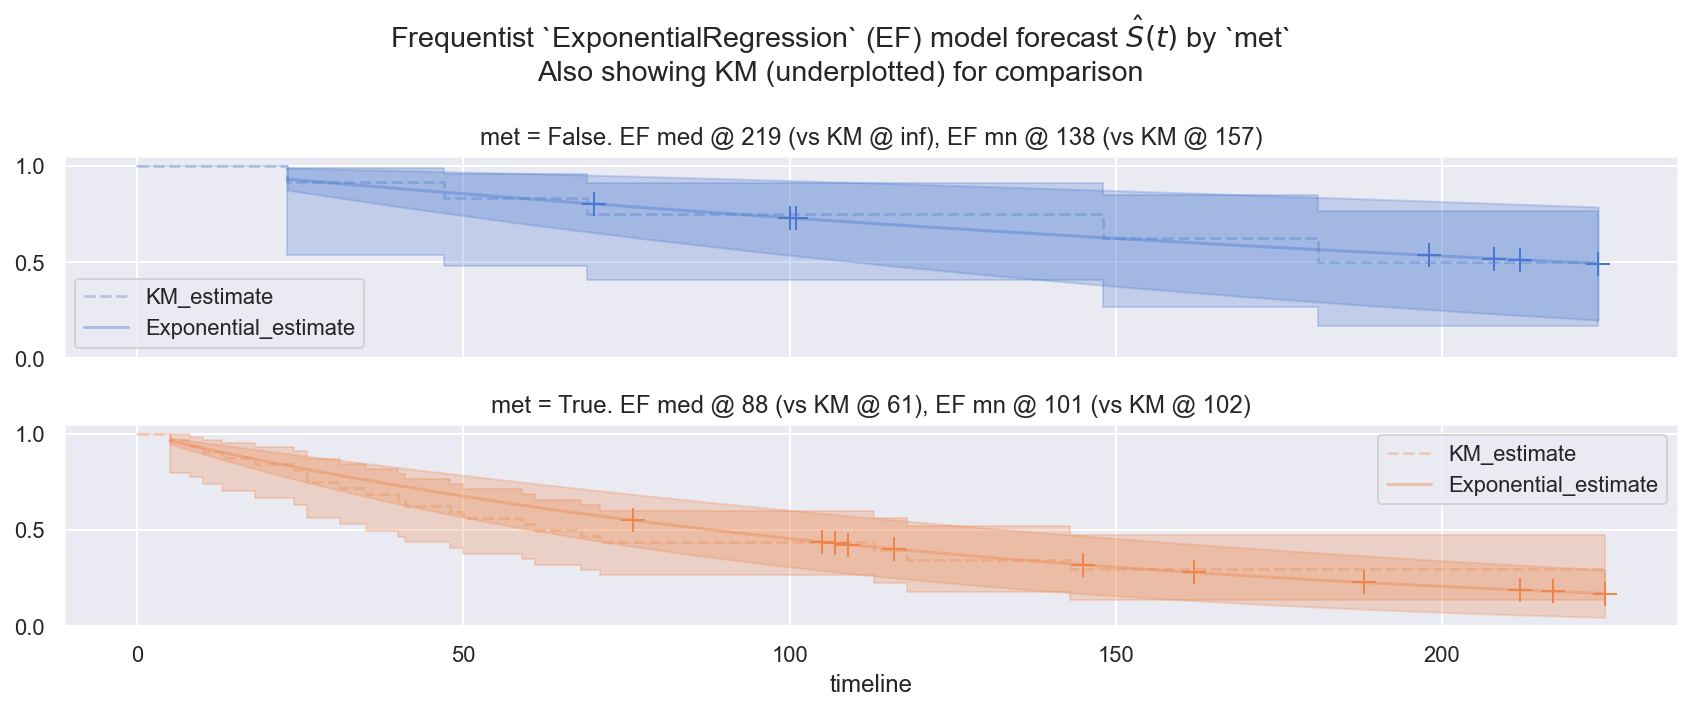

In [9]:
f, axs = plt.subplots(2, 1, figsize=(12, 5), sharey=True, sharex=True)
ax0 = kmf[False].plot_survival_function(ax=axs[0], color='C0', alpha=0.3, linestyle='--')
ax0 = exf[False].plot_survival_function(ax=axs[0], show_censors=True, color='C0', alpha=0.4)
ax1 = kmf[True].plot_survival_function(ax=axs[1], color='C1', alpha=0.3, linestyle='--')
ax1 = exf[True].plot_survival_function(ax=axs[1], show_censors=True, color='C1', alpha=0.4)

_ = ax0.set_title(f'met = False. EF med @ {f_med:.0f} (vs KM @ {f_med_km:.0f})'
                    + f', EF mn @ {f_mn:.0f} (vs KM @ {f_mn_km:.0f})')
_ = ax1.set_title(f'met = True. EF med @ {t_med:.0f} (vs KM @ {t_med_km:.0f})'
                    + f', EF mn @ {t_mn:.0f} (vs KM @ {t_mn_km:.0f})')

_ = f.suptitle('Frequentist `ExponentialRegression` (EF) model forecast $\hat{S}(t)$ by `met`'+
                '\nAlso showing KM (underplotted) for comparison')
_ = f.tight_layout()

**Observe:**

+ The exponential estimator `ExponentialFitter` is now much closer to the empirical pattern created by the 
  deterministic `KaplanMeierFitter` at the `met` group level
+ We see expected values `mn` broadly in agreement, but note the `met = True` group is larger than `met = False`, 
  and `death = True | met = True` is larger than `death = False | met = True`, so as we would expect, the predictions 
  for `met = True` group are better defined. See `00_Intro.ipynb` $\S 1.1$ Example Frequency Tables & Lifetime Plots
+ Also this time we get a real value for `met = False. EF med @ 219` (not `inf`) because the `ExponentialFitter` is 
  parametric
+ However, this is still a very basic model and the grouped univariate (fully unpooled categorical) modelling approach
  won't scale any further

### 2.1.2 Extract estimated hazard rate $\hat{\gamma}$ from exponential model

In [10]:
ci_vals = exf[True].confidence_interval_hazard_.iloc[0].values
gamma_est = np.array([ci_vals[0], 1 / exf[True].lambda_, ci_vals[1]])
print(f'met=True: {gamma_est}')
ci_vals = exf[False].confidence_interval_hazard_.iloc[0].values
gamma_est = np.array([ci_vals[0], 1 / exf[False].lambda_, ci_vals[1]])
print(f'met=False: {gamma_est}')

met=True: [0.00463712 0.00786517 0.01109321]
met=False: [0.00050248 0.00316256 0.00582263]


**Observe:**

+ Our frequentist exponential model estimates `gamma`:
  + For `met=True`, $\hat{\gamma} \sim 0.008 \in [0.005, 0.011]_{CI94}$
  + For `met=False`, $\hat{\gamma} \sim 0.003 \in [0.001, 0.006]_{CI94}$
+ So it appears that presence of `met` more than doubles the **hazard rate**
+ These values appear substantially different, and if we took the effort, we could
  potentially use these frequentist results to qualify a difference between the
  groups - sufficient to disprove the null hypothesis that they're the same value,
  and thus provide a claim of "statistical significance"
+ We will not do this, because Bayesian estimation is far superior (see 
  [Case Study: Bayesian Estimation Supersedes the T-Test](https://www.pymc.io/projects/examples/en/latest/case_studies/BEST.html])
  and citations) and we will BEST-test later

---

---

# 3. Custom Bayesian Model `ExponentialRegression`

Now the Bayesian workflow kicks into gear, because we will be able to easily specify the linear model substructure, and 
demonstrate improvement over the `exponential_univariate` model via the log-likelihood performance via LOO-PIT.

Again refer to `000_Intro.ipynb` $\S \text{Preamble}$ for the myriad reasons this is a better general method to use.

We will improve on this in the __20x_AFT family__ series of notebooks with several innovations

## 3.0 Prepare & Transform Dataset for Linear Model

This is a preparatory step to transform the observational data into a form for
use in the custom Bayesian models. We will use this transformed dataset `dfx` 
in all subsequent models where possible

NOTE:

+ For this example Notebook we will _not_ partition into train & holdout sets
  (see `README.md ## 5. Data Standards` for terminology)
+ Instead we will simply fit the entire dataset and evaluate in-sample using
  Pareto-smoothed Leave-One-Out (LOO-PIT) cross-validation testing
+ This means we still follow our standard process for preparation, 
  transformation, standardization, but abbreviate to `dfa` only


In-house preferred process (transformation, standardization) to create `dfx` for model usage 

In [11]:
dfx_creator = utils.ProjectDFXCreator()
dfx = dfx_creator.get_dfx(df)
eda.describe(dfx)

,3,30,36,dtype,count_null,count_inf,count_zero,count_unique,top,freq,sum,mean,std,min,25%,50%,75%,max
ft,,,,,,,,,,,,,,,,,,
index: pid,p3,p30,p36,object,0,NaN,NaN,44,p0,1,NaN,NaN,NaN,p0,NaN,NaN,NaN,p9
duration,70,76,118,int64,0,0.0,0.0,NaN,NaN,NaN,4251.0,96.61,69.87,5.0,38.75,73.5,145.75,225.0
death_t_true,0,0,1,int64,0,0.0,18.0,NaN,NaN,NaN,26.0,0.59,0.5,0.0,0.0,1.0,1.0,1.0
intercept,1.0,1.0,1.0,float64,0,0.0,0.0,NaN,NaN,NaN,44.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
met_t_true,0,1,1,int64,0,0.0,12.0,NaN,NaN,NaN,32.0,0.73,0.45,0.0,0.0,1.0,1.0,1.0


'Shape: (44, 5), Memsize 0.0 MB'

## 3.1 Build Model Object

`ExponentialRegression` model imported from `src.models.exponential.py` where it is fully defined

In [12]:
mdl_er = exponential.ExponentialRegression(obs=dfx, fts_en=dfx_creator.fts_en, 
                                        factor_map=dfx_creator.factor_map, obs_nm='dfx')
mdl_er.build()
utils.display_rvs(mdl_er)
mdl_er.debug()

'RVs for exponential_regression, v1.0.2, dfx'

beta ~ Normal(-2, 2)

gamma ~ Deterministic(f(beta))

shat ~ Deterministic(f(beta))

point={'beta': array([-2., -2.])}

No problems found
point={'beta': array([-2., -2.])}

No problems found


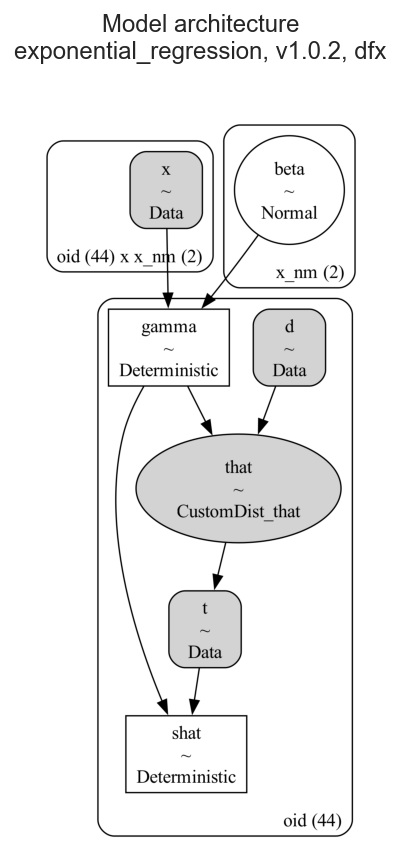

In [13]:
fqn = mdlio.write_graph(mdl_er)  # output model graph to prove built
f = figio.read(fqn=fqn, title=f'Model architecture\n{mdl_er.mdl_id}', figsize=(12, 6))

## 3.2 Sample Prior Predictive, View Diagnostics

In [14]:
mdl_er.sample_prior_predictive(var_names=mdl_er.rvs_b + mdl_er.rvs_ppc, replace=True)

#### Evaluate PPC vs In-Sample Data

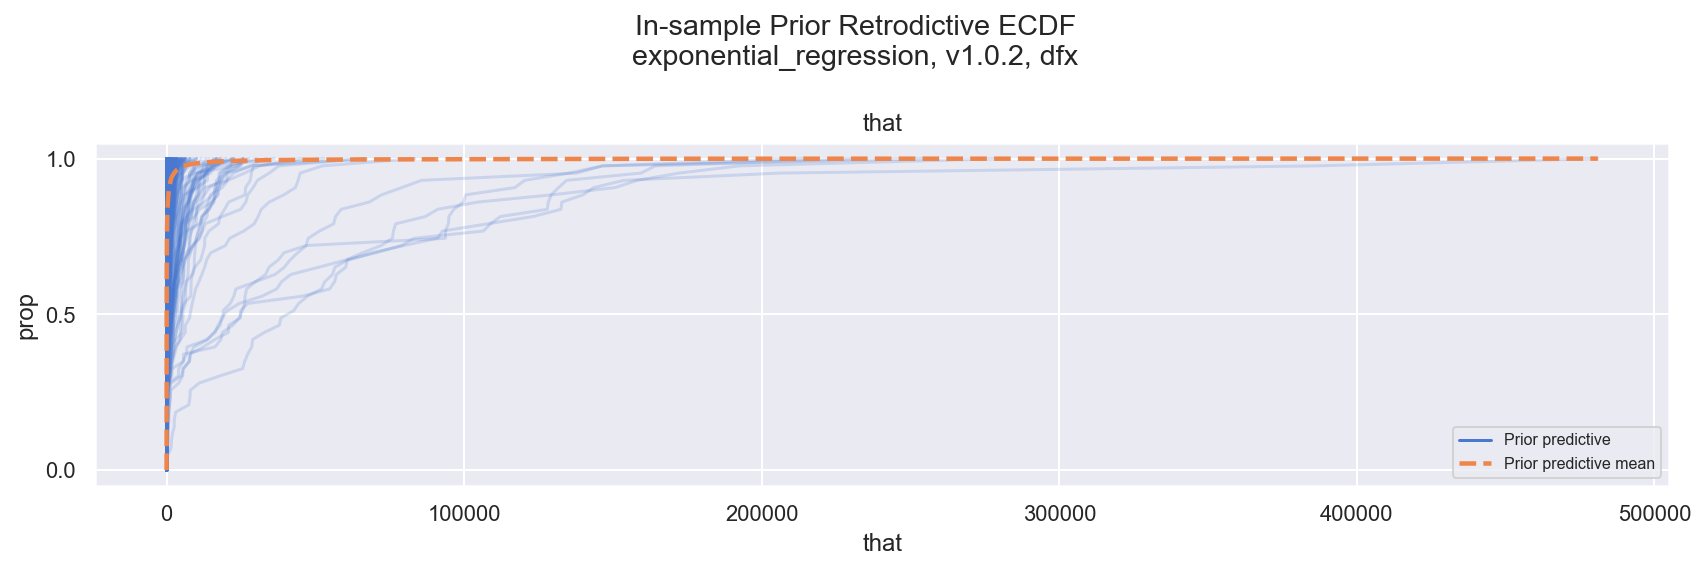

In [15]:
GRP = 'prior'
f = mt.plot_ppc(mdl=mdl_er, group=GRP, var_names=['that'], insamp=True)

**Observe:**

+ Terrible fit as expected, but the range is valid (if large)

#### Evaluate priors and hyperpriors

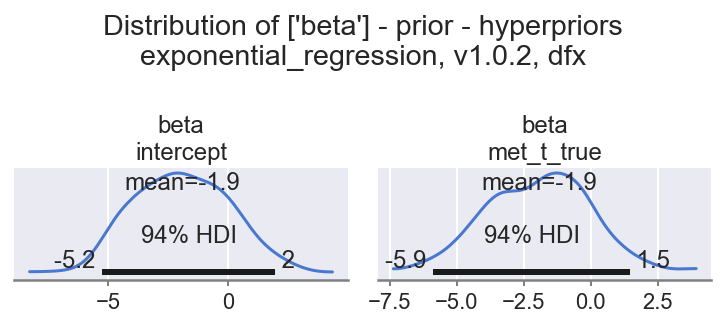

In [16]:
f = mt.facetplot_krushke(mdl=mdl_er, group=GRP, txtadd='hyperpriors', rvs=mdl_er.rvs_b, m=2)

**Observe:**

+ We've set these priors to be relatively uninformative, but deliver a $\gamma = \beta^{T}\mathbf{x}$ that includes the 
  KM estimate of $\gamma \sim 0.003$ i.e.:
  + At the mean of the prior of both distributions $[-2, -2]$, and at $x = 1$, the resulting $\gamma = \exp(-2 + -2) \approx 0.0183$
  + At the HDI94_min of the prior of both distributions $[-6, -6]$, and at $x = 1$, the resulting $\gamma = \exp(-6 + -6) \approx 0.000006$
  + At the max of the prior of both distributions $[2, 2]$, and at $x = 1$, the resulting $\gamma = \exp(2 + 2) \approx 55$

## 3.3 Sample Posterior, View Diagnostics

In [17]:
mdl_er.sample(progressbar=True)
mdl_er.sample_posterior_predictive(store_ppc=True, ppc_insample=True, var_names=mdl_er.rvs_ppc)
mdlio.write_idata(mdl=mdl_er)

Output()

Output()

PosixPath('/Users/jon/workspace/oreum/oreum_survival/data/models/idata_exponential_regression_v102_dfx.netcdf')

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[intercept],-5.557,0.386,-6.252,-4.807,0.018,0.013,504.0,625.0,1.0
beta[met_t_true],0.660,0.432,-0.132,1.480,0.019,0.014,538.0,562.0,1.0


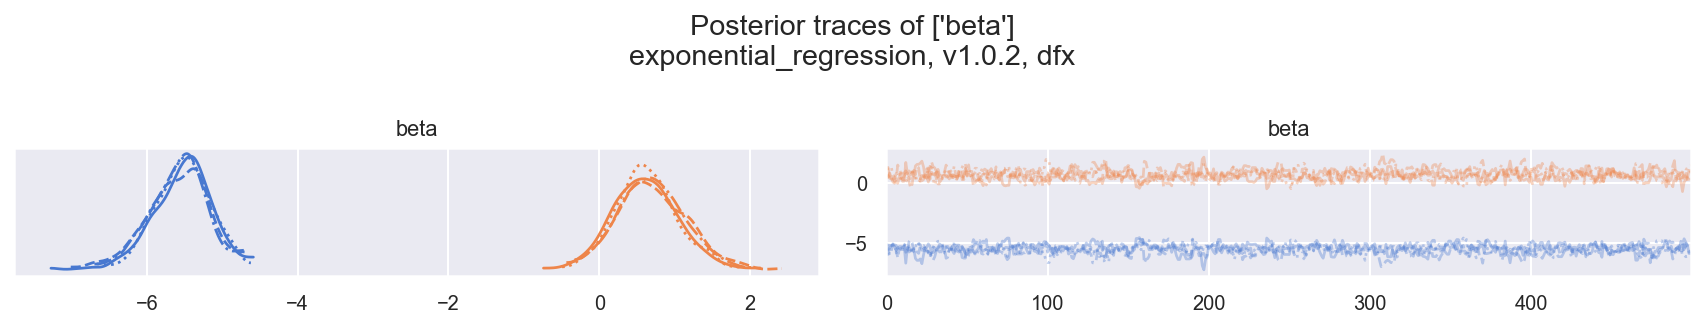

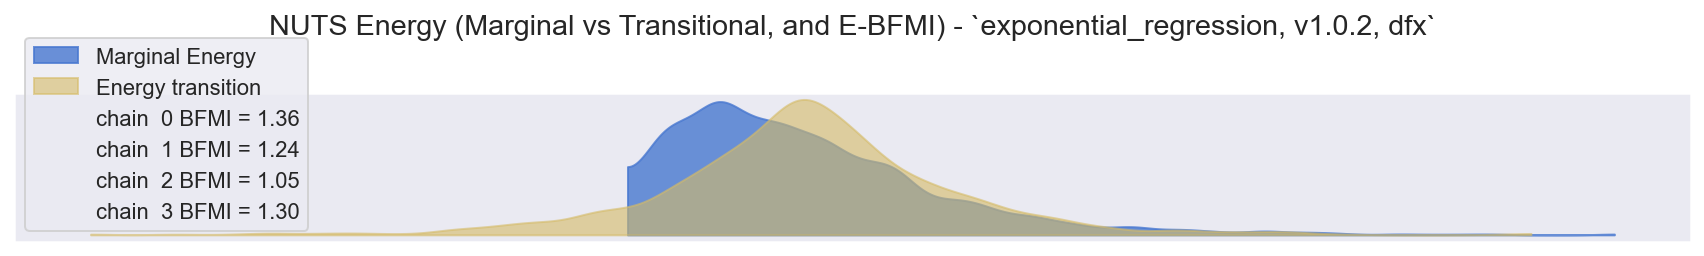

In [18]:
f = mt.plot_trace(mdl=mdl_er, rvs=mdl_er.rvs_b, kind='trace')
f = mt.plot_energy(mdl=mdl_er)
smry = mt.get_summary(mdl=mdl_er, rvs=mdl_er.rvs_b)
smry

**Observe:**

+ Posterior distributions reasonably smooth and central
+ Samples well-mixed and well-behaved: `ess_bulk` is good, `r_hat` is good
+ Marginal energy | energy transition looks okay: `E-BFMI > 0.3` so [apparently reasonable](https://python.arviz.org/en/stable/api/generated/arviz.bfmi.html#arviz.bfmi)

## 3.4 Evaluate Posterior PPC (In-Sample) via ECDF

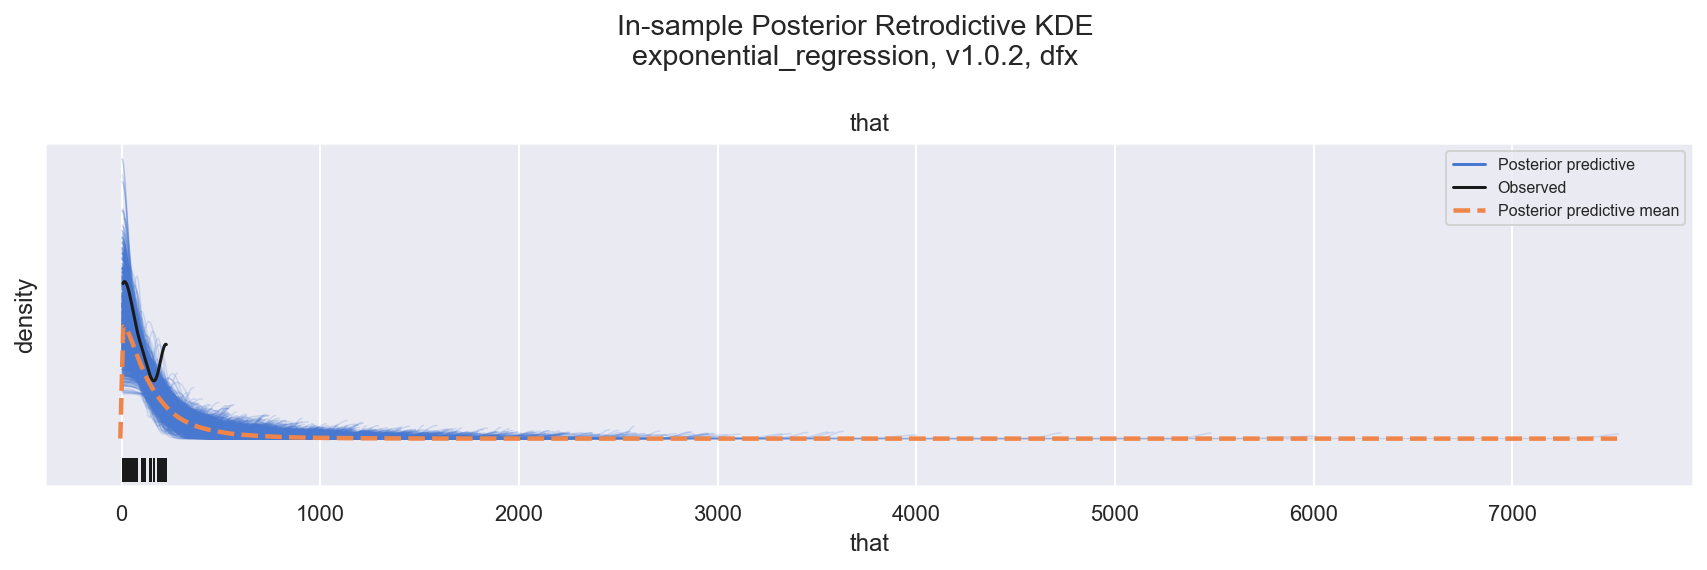

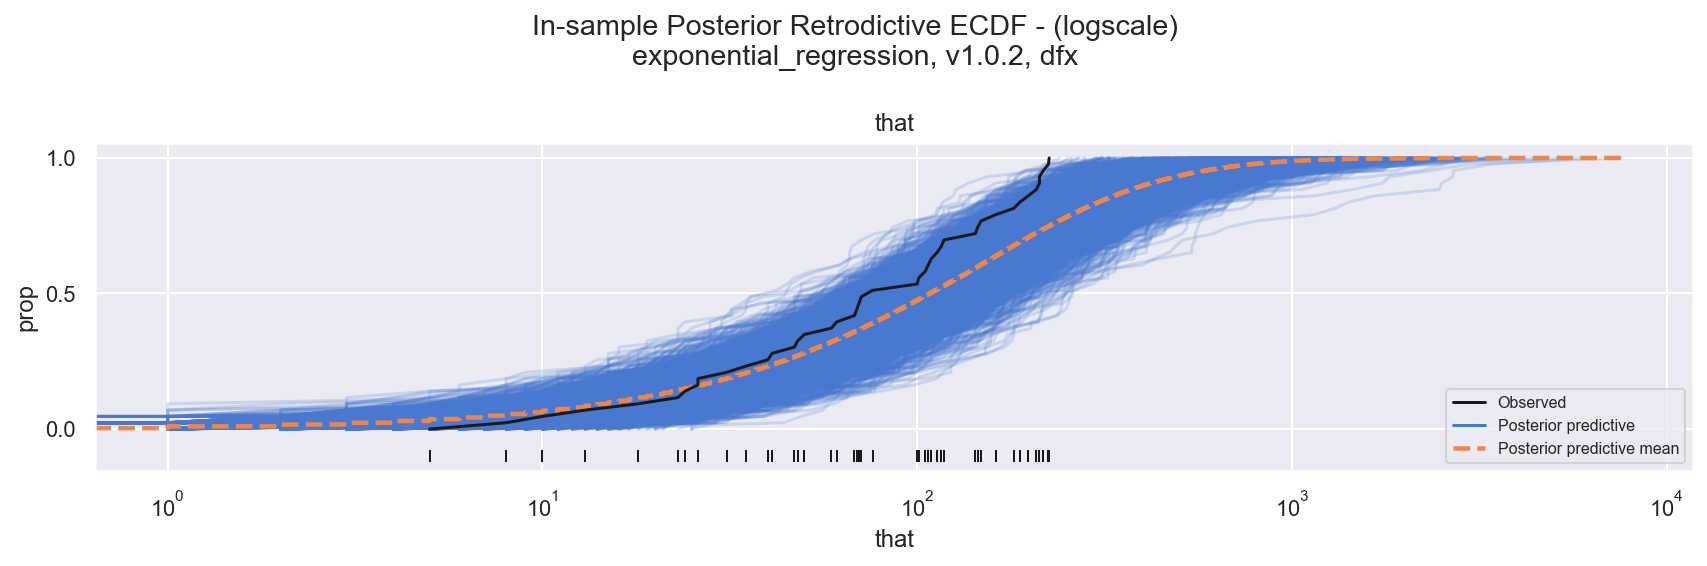

In [19]:
GRP = 'posterior'
f = mt.plot_ppc(mdl=mdl_er, group=GRP, var_names=['that'], ecdf=False, insamp=True)
f = mt.plot_ppc(mdl=mdl_er, group=GRP, var_names=['that'], insamp=True, logx=True)

**Observe:**

+ We have an approximate fit, but it's pretty extended to the right of the cumulative observations (overdispersed) - room to improve!

## 3.5 Evaluate via LOO-PIT plots (In-Sample)

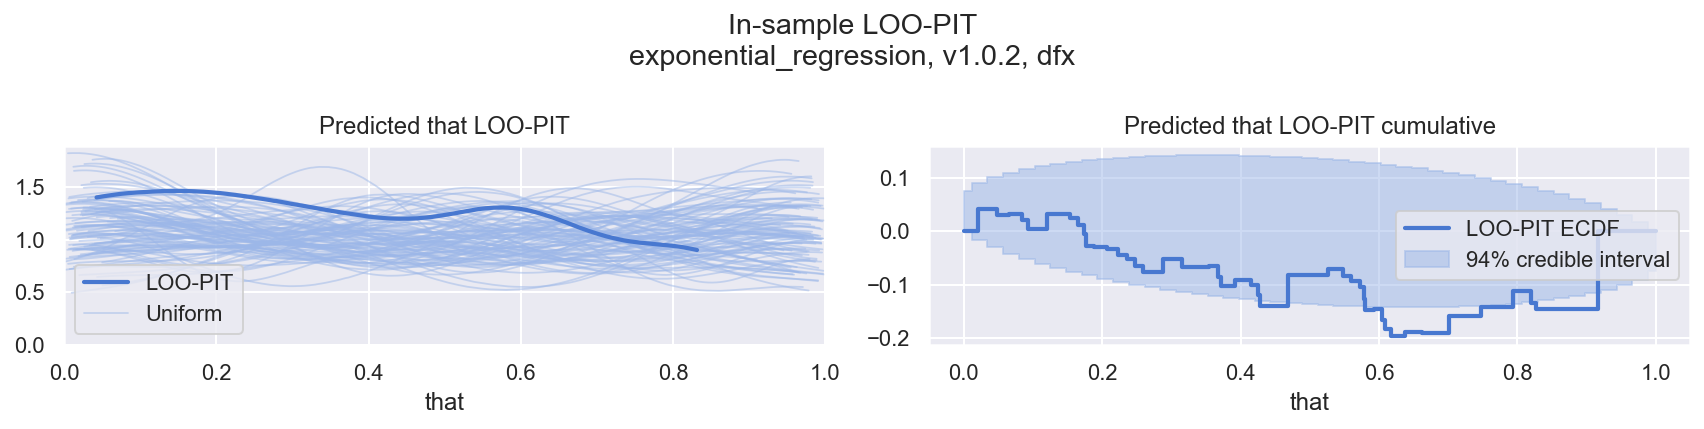

In [20]:
f = mt.plot_loo_pit(mdl_er, data_pairs={'that': 'that'})

**Observe**

+ Again we see the poor fit: the predictions of yhat appear overdispersed compared to the observed data

## 3.6 Compare Log-Likelihood vs other models

### 3.6.1 Reinstantiate earlier models for comparison

In [21]:
mdl_eu = exponential.ExponentialUnivariate(obs=dfx, fts_en=dfx_creator.fts_en, 
                                        factor_map=dfx_creator.factor_map, obs_nm='dfx')
mdl_eu.build()
mdl_eu_idata = mdlio.read_idata(mdl=mdl_eu)
mdl_eu.update_idata(idata=mdl_eu_idata)

### 3.6.2 Compare

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
mdl_er\nexponential_regression_v102_dfx,0,-158.680736,2.083518,0.000000,0.871232,14.643382,0.000000,False,log
mdl_eu\nexponential_univariate_v102_dfx,1,-159.612908,1.179682,0.932172,0.128768,14.892223,1.575394,False,log


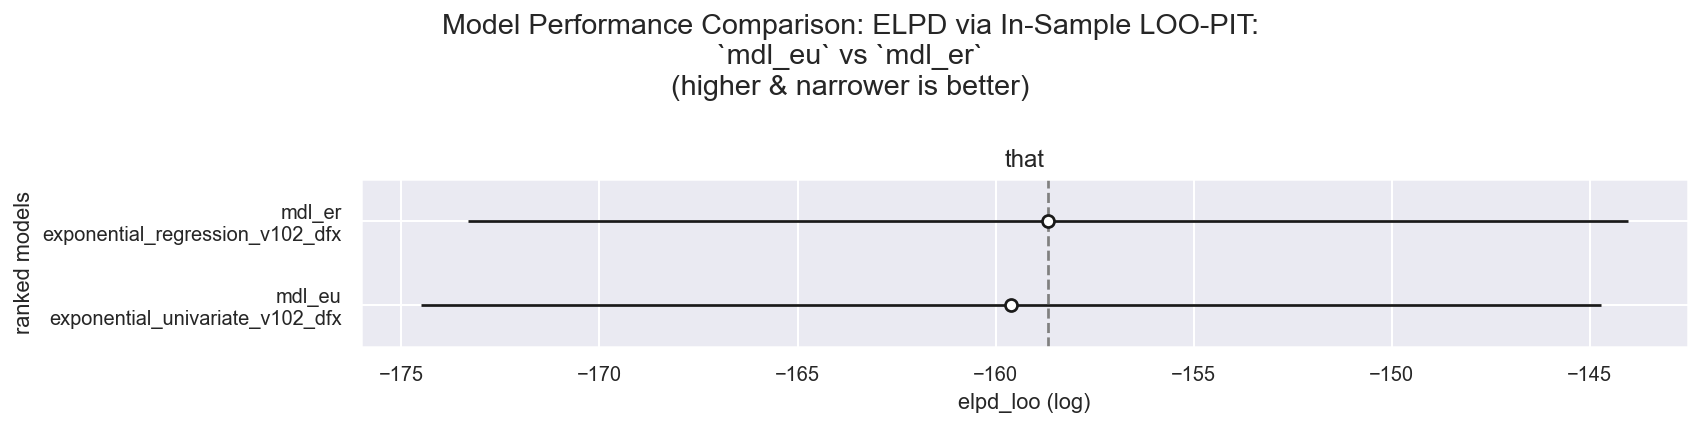

In [22]:
mdl_dict = {'mdl_eu': mdl_eu, 'mdl_er': mdl_er}
f, dcomp = mt.plot_compare(mdl_dict, yhats=['that'])
_ = [display(d) for d in dcomp.values()]

**Observe:**

+ `exponential_regression` has the best in-sample `elpd_loo`, but only by a small
  delta, and the overlap is considerable
+ We would be mildly justified in using the `exponential_regression` model, but 
  should still attempt more complicated and hopefully more performant models

In [23]:
del mdl_eu

## 3.7 Evaluate Posterior Parameters

### 3.7.1 Hyperpriors `beta`

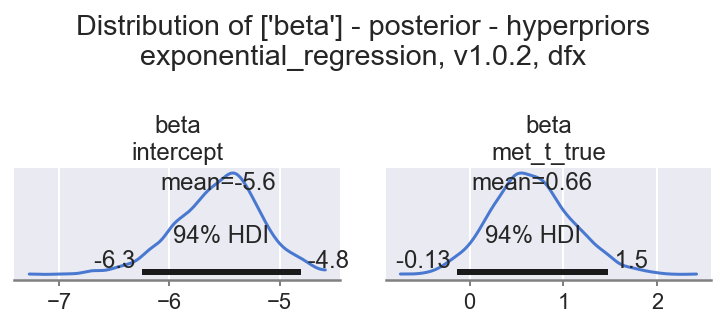

In [24]:
GRP = 'posterior'
f = mt.facetplot_krushke(mdl=mdl_er, group=GRP, txtadd='hyperpriors', rvs=mdl_er.rvs_b, m=2)

**Observe**

+ NOTE `beta: intercept` carries the value for `met=False`, and `beta: met_t_true` carries the value for `met=True`
+ Both have a substantial bulk away from zero, and have a neglgible overlap, implying a substantial difference

> We will demonstrate this below via a [BEST test](https://www.pymc.io/projects/examples/en/latest/case_studies/BEST.html]) on the direct transformation `gamma`

### 3.7.2 View posterior estimates of the direct transformation `gamma`

NOTE: 

+ This is only feasible because we have such a simple linear model `1 + met`,
  and `met` is boolean, so `gamma` is a binary grouping
+ This lets us compare to the frequentist Exponential model

,dtype,sum,mean,std,min,3%,25%,50%,75%,97%,max
ft,,,,,,,,,,,
met=False,float64,8.293,0.004,0.002,6.938e-04,0.002,0.003,0.004,0.005,0.008,0.010
met=True,float64,15.288,0.008,0.002,2.845e-03,0.005,0.006,0.008,0.009,0.011,0.014


'Shape: (2000, 2), Memsize 0.0 MB'

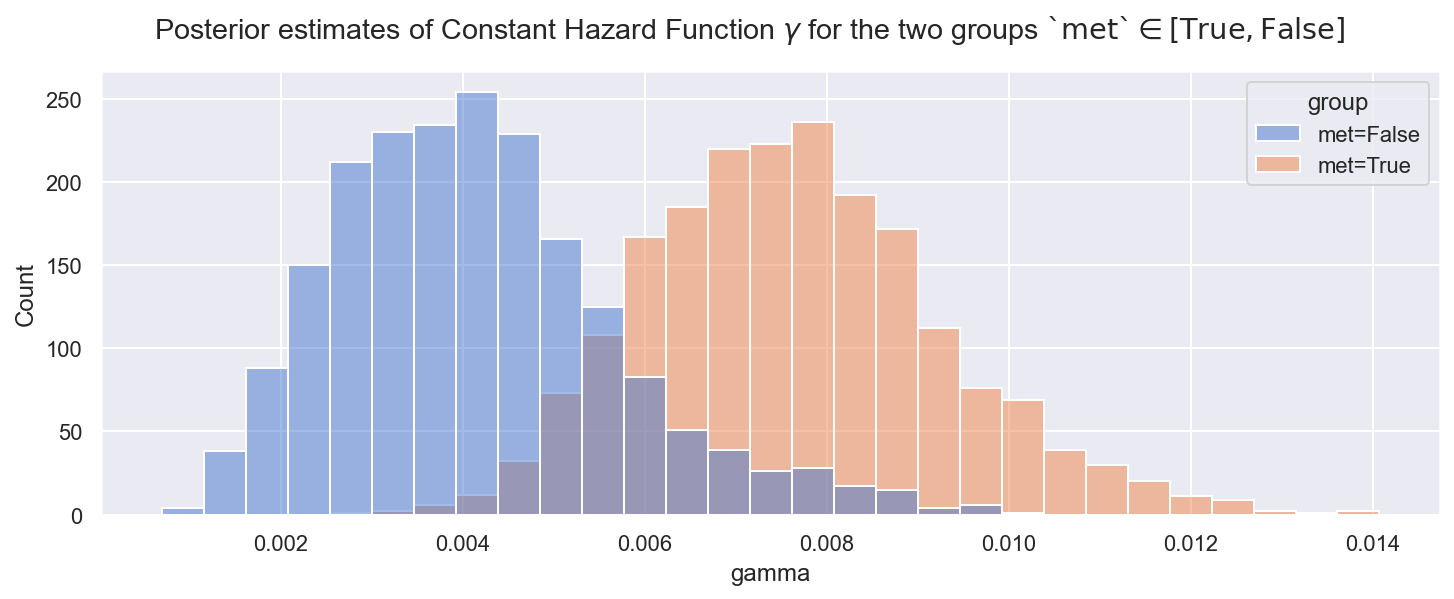

In [25]:
b = az.extract(mdl_er.idata, group='posterior', var_names='beta').values
x = np.array([[1, 0], [1, 1]])
df_ghat = pd.DataFrame(np.exp(np.dot(x, b)).T, columns=['met=False', 'met=True'], index=np.arange(2000))
mn = df_ghat.mean(axis=0).values
hdi94 = np.quantile(df_ghat, q=[0.03, 0.97], axis=0)

dfm = df_ghat.melt(var_name='group', value_name='gamma')
f, axs = plt.subplots(1, 1)
ax = sns.histplot(x='gamma', hue='group', data=dfm, ax=axs)
_ = f.suptitle('Posterior estimates of Constant Hazard Function $\gamma$ for the two groups $\\text{`met`} \in [\\text{True}, \\text{False}]$')
eda.describe(df_ghat, reset_index=False, nobs=0, get_cr94=True, get_counts=False, precision=3)

+ Our Bayesian exponential regression model estimates `gamma`:
+ + For `met=False`, $\hat{\gamma} \sim 0.004 \in [0.002, 0.008]_{HDI94}$
  + For `met=True`, $\hat{\gamma} \sim 0.008 \in [0.003, 0.011]_{HDI94}$
+ Again it appears that presence of `met` approx doubles the **hazard rate**

### 3.7.3 BEST test of the difference in gamma between groups

For completeness' sake, and again note this is only feasible because we have 
such a simple linear model `1 + met`, and `met` is boolean, so `gamma` is a 
binary grouping.

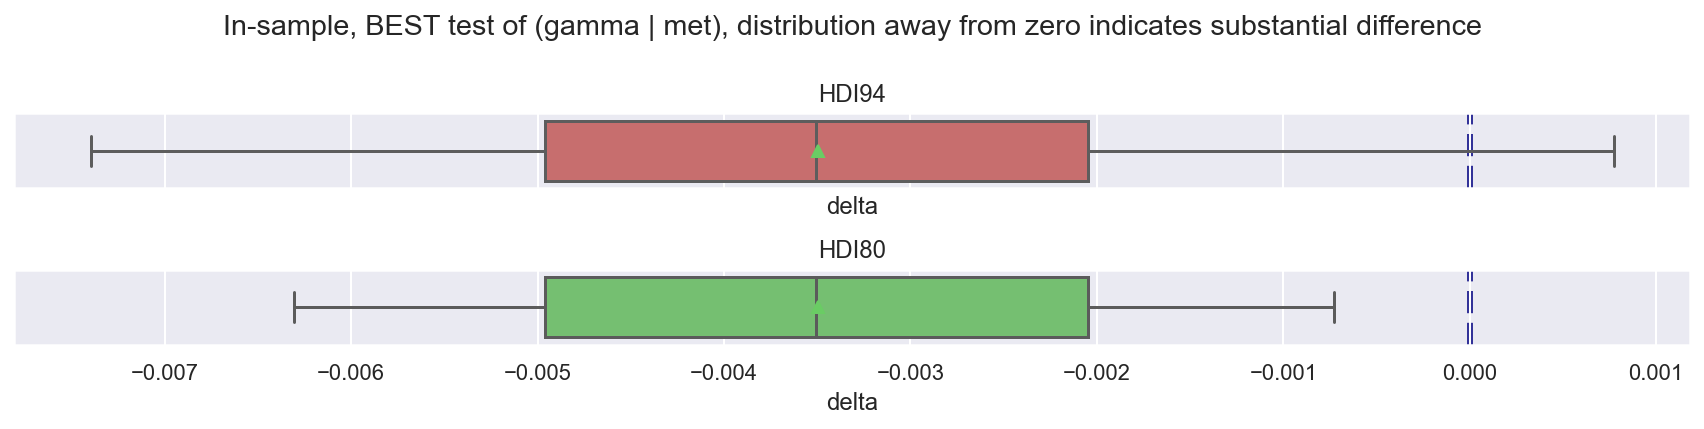

In [26]:
df_ghat['delta'] = df_ghat.iloc[:, 0] - df_ghat.iloc[:, 1]
f, axs = plt.subplots(2, 1, figsize=(12, 3), sharex=True)
ax0 = sns.boxplot(x='delta', data=df_ghat, sym='', whis=[3, 97], showmeans=True, ax=axs[0], color='C3')
ax1 = sns.boxplot(x='delta', data=df_ghat, sym='', whis=[10, 90], showmeans=True, ax=axs[1], color='C2')
_ = ax0.set_title('HDI94')
_ = ax1.set_title('HDI80')
_ = ax0.axvline(0, ls='--', lw=3, c='#333399', zorder=-1)
_ = ax1.axvline(0, ls='--', lw=3, c='#333399', zorder=-1)
_ = f.suptitle('In-sample, BEST test of (gamma | met), distribution away from zero indicates substantial difference')
_ = f.tight_layout()

**Observe:**

+ This simple BEST test shows a distribution of delta with the bulk far from zero
+ Zero is still within `HDI94`, so _not_ an appreciable effect at `HDI94`
+ Zero is however outside the `HDI80`, so _it is_ an appreciable effect at `HDI80`

> The HDI94 is entirely arbitrary, and chosen to echo the conventional level of "statistical significance" at p=0.05, 
> The CR80 is also entirely arbitrary

## 3.8 Forecast Survival $\hat{S}(t)$ and Expected Time-to-Event $\hat{\mathbb{E}}_{t}$

Because this model is parametric, we can **forecast** Survival $\hat{S}(t)$ and Expected Time-to-Event 
  $\hat{\mathbb{E}}_{t}$ for observations in an **out-of-sample dataset**

> See the full detailled discussion in `100_Exponential_Univariate.ipynb` $\S3.8$

### 3.8.1 Create synthetic dataset, calc PPC and extract PPC components

In [27]:
dfs = utils.get_synthetic_df_oos(df, ndur=20)
dfsx = dfx_creator.get_dfx(dfs, in_sample=False)

mdl_er.replace_obs(obsd={'obs': dfsx}, obs_nm='dfsx')
mdl_er.build()
f_idata = mdl_er.sample_posterior_predictive(store_ppc=False, ppc_insample=True, var_names=mdl_er.rvs_ppc)
dfhat = utils.get_ppc_components_as_dfm(f_idata, getx=True)
dfp = pd.merge(dfhat, dfs.reset_index(), how='left', left_on='oid', right_on='pid')
eda.display_ht(dfp)

Output()

,oid,chain,draw,shat,that,oid_sub,t,intercept,met_t_true,pid,met,death,duration
0,z000-0,0,0,1.00,35.0,z000,0,1.0,0.0,z000-0,False,False,0
1,z000-0,0,1,1.00,616.0,z000,0,1.0,0.0,z000-0,False,False,0
2,z000-0,0,2,1.00,572.0,z000,0,1.0,0.0,z000-0,False,False,0
79997,z001-226,3,497,0.30,95.0,z001,226,1.0,1.0,z001-226,True,False,226
79998,z001-226,3,498,0.28,20.0,z001,226,1.0,1.0,z001-226,True,False,226
79999,z001-226,3,499,0.28,72.0,z001,226,1.0,1.0,z001-226,True,False,226


'Shape: (80000, 13), Memsize 8.3 MB'

### 3.8.2 Plot estimated Survival $\hat{S}(t)$

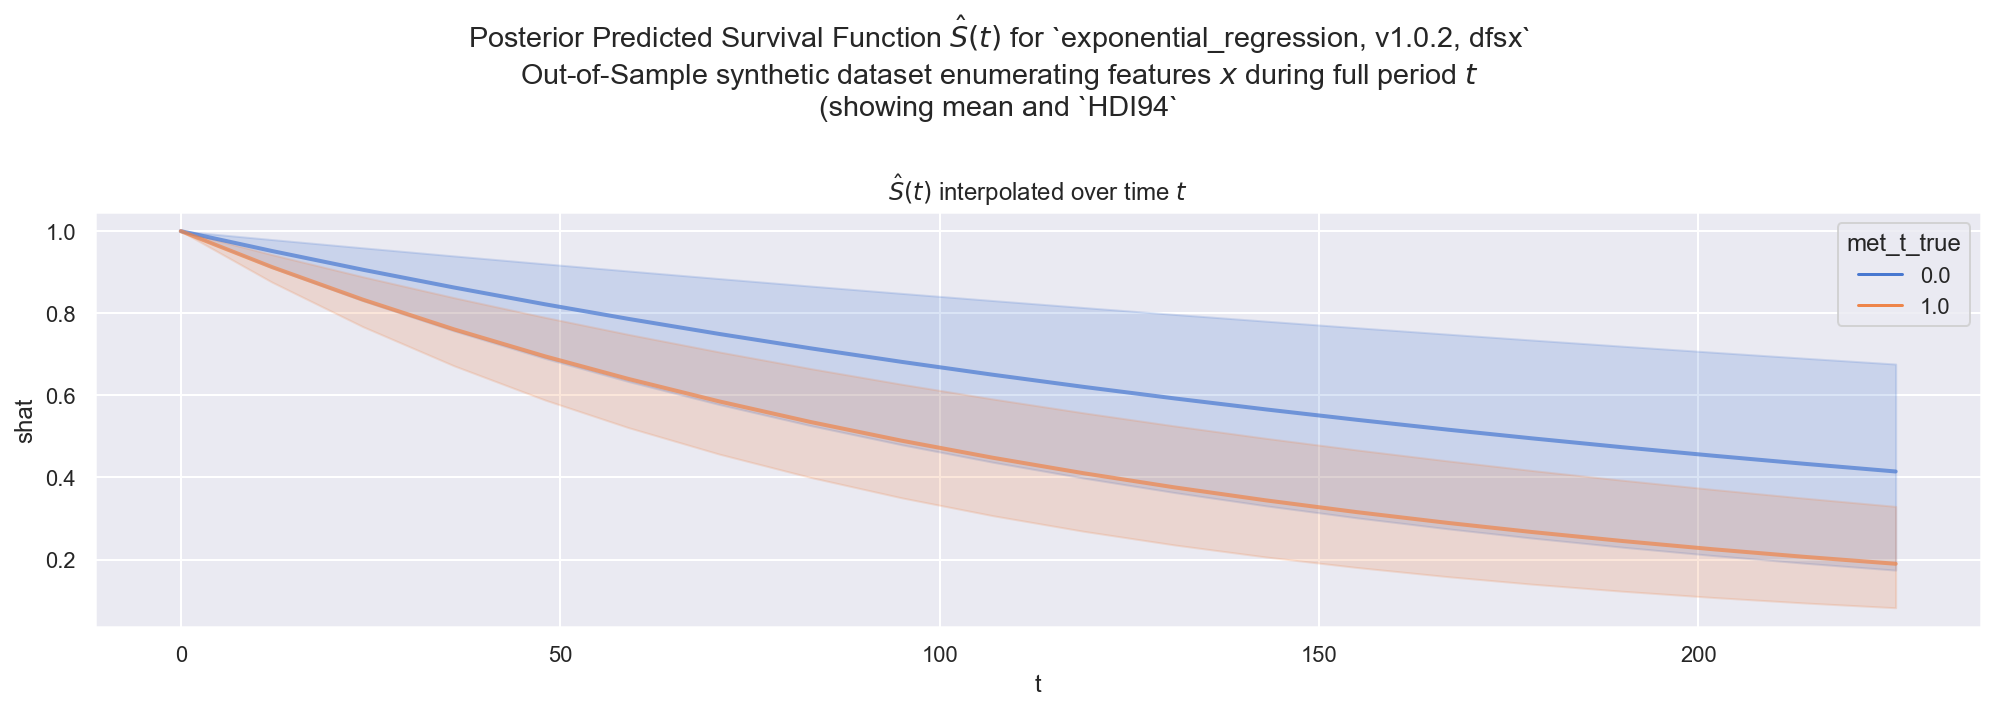

In [28]:
f, axs = plt.subplots(1, 1, figsize=(14, 5), sharex=False)
ax = sns.lineplot(x='t', y='shat',  hue='met_t_true', style='met_t_true', data=dfp, ms=10, dashes=False, 
        alpha=0.7, legend=True, lw=2, ax=axs, estimator='mean', errorbar=('pi', 94), err_style='band')
_ = ax.set_title('$\hat{{S}}(t)$ interpolated over time $t$')
_ = f.suptitle(f'Posterior Predicted Survival Function $\hat{{S}}(t)$ for `{mdl_er.mdl_id}`'
            + '\nOut-of-Sample synthetic dataset enumerating features $x$ during full period $t$'
            + '\n(showing mean and `HDI94`')
_ = f.tight_layout()
fqn = figio.write(f, fn=f'101_{mdl_er.mdl_id}_forecast_shat')

**Observe:**

+ Again we see the predicted survival curves are distinct
+ Again we see the parametric model overestimates survival (overdispersed)

### 3.8.3 Plot estimated Expected Time-to-Event $\hat{\mathbb{E}}_{t}$

We will only use Option A: Based on idealised parametric $\hat{\mathbb{E}}_{t} \sim S^{-1}(u) \sim 1/\gamma * (− \log u )$

Recap on Freqentist model summary statistics for comparison:
met = False. EF med @ 219 (vs KM @ inf), EF mn @ 138 (vs KM @ 157)
met = True. EF med @ 88 (vs KM @ 61), EF mn @ 101 (vs KM @ 102)


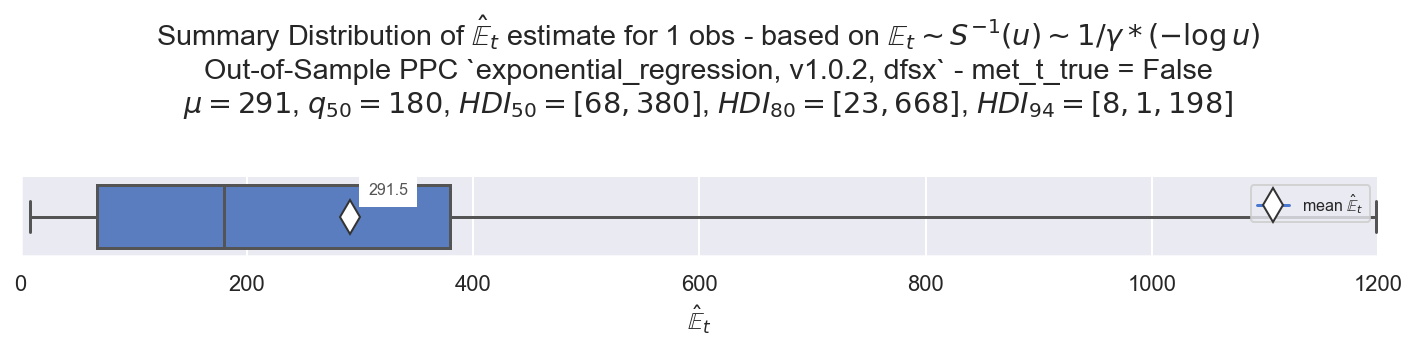

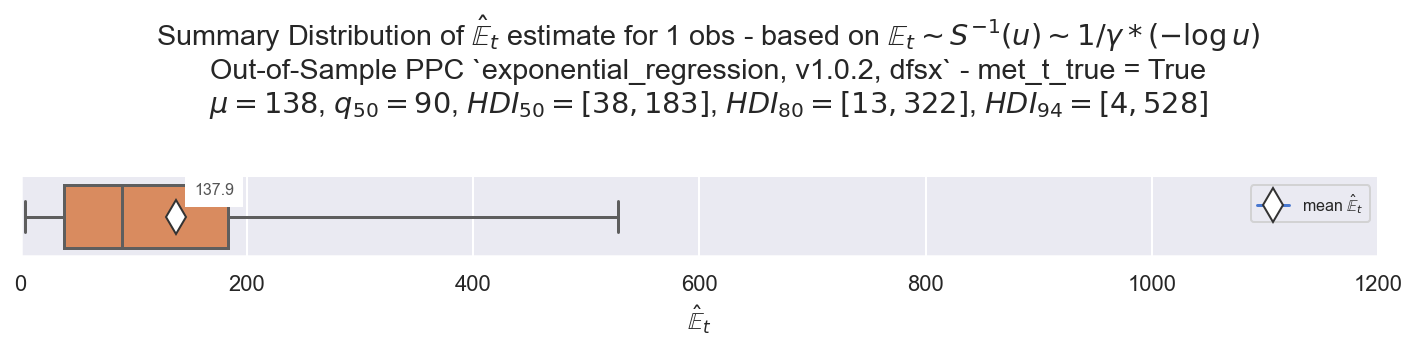

In [29]:
df_et = dfp.loc[dfp['t']==0].groupby(['pid', 'chain', 'draw', 'met_t_true'])['that'].mean().to_frame('$\hat{\mathbb{E}}_{t}$')

f = eda.plot_estimate(df=df_et.loc[:, :, :, 0], nobs=1, yhat='$\hat{\mathbb{E}}_{t}$',
    txtadd=(f'based on $\mathbb{{E}}_{{t}} \sim S^{{-1}}(u) \sim 1/\gamma * (− \log u )$'
    +f'\nOut-of-Sample PPC `{mdl_er.mdl_id}` - met_t_true = False'), force_xlim=(0, 1200))
fqn = figio.write(f, fn=f'101_{mdl_er.mdl_id}_forecast_et_met_false')

f = eda.plot_estimate(df=df_et.loc[:, :, :, 1], nobs=1, yhat='$\hat{\mathbb{E}}_{t}$',
    txtadd=(f'based on $\mathbb{{E}}_{{t}} \sim S^{{-1}}(u) \sim 1/\gamma * (− \log u )$'
    +f'\nOut-of-Sample PPC `{mdl_er.mdl_id}` - met_t_true = True'), force_xlim=(0, 1200), color='C1')
fqn = figio.write(f, fn=f'101_{mdl_er.mdl_id}_forecast_et_met_true')

print('Recap on Freqentist model summary statistics for comparison:')
print(f'met = False. EF med @ {f_med:.0f} (vs KM @ {f_med_km:.0f})'+ f', EF mn @ {f_mn:.0f} (vs KM @ {f_mn_km:.0f})')
print(f'met = True. EF med @ {t_med:.0f} (vs KM @ {t_med_km:.0f})'+ f', EF mn @ {t_mn:.0f} (vs KM @ {t_mn_km:.0f})')

**Observe:**

+ Regressing onto `met` has allowed model `exponential_regression` to produce predictions that look far more tailored to the data
+ As mentioned above, `met = False` is the less populus group and the distribution of $\hat{\mathbb{E}}_{t}$ is commensurately wider
  + The mean $\mu \sim 291$ is higher than the Freqentist `EF` model (at $138$), but the medians agree quite closely (180 and 219 respectively)
+ The `met = True` group is the larger group and the distribution of $\hat{\mathbb{E}}_{t}$ is commensurately narrower
  + The mean $\mu \sim 138$ is higher than the Freqentist `EF` model (at $101$), but the medians agree quite closely (90 and 88 respectively)

**NOTE**

+ We don't have to always compare the far more sophisticated Bayesian model with the Frequentist model, and as we improve the
  Bayesian model architecture, such a comparison becomes impossible anyhow (the Frequentist model cant be built)
+ But in these early stages it can still be useful to give a grounding of the new vs the old methods

---

---

# Notes

In [30]:
%load_ext watermark
%watermark -a "jonathan.sedar@oreum.io" -udtmv -iv -p pymc,pytensor

Author: jonathan.sedar@oreum.io

Last updated: 2024-11-18 17:55:27

Python implementation: CPython
Python version       : 3.11.10
IPython version      : 8.29.0

pymc    : 5.16.2
pytensor: 2.25.5

Compiler    : Clang 17.0.6 
OS          : Darwin
Release     : 23.6.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

arviz     : 0.20.0
sys       : 3.11.10 | packaged by conda-forge | (main, Oct 16 2024, 01:26:25) [Clang 17.0.6 ]
numpy     : 1.26.4
oreum_core: 0.9.7
seaborn   : 0.12.2
lifelines : 0.30.0
matplotlib: 3.9.2
pyprojroot: 0.3.0
pandas    : 2.2.3



---
**Oreum OÜ &copy; 2024**